In [2]:
#%%
# Section of the Python code where we import all dependencies on third party Python modules/libaries or our own
# libraries (exposed C++ code to Python, i.e. darts.engines && darts.physics)
from model_deadoil import ModelDA
import numpy as np
import meshio
from darts.engines import *

import concurrent.futures
import math
import os
import re
import shutil
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd
import scipy.stats as stats

In [3]:
#%%
#function to get an angle and output apertures 
DIR = 'mesh_files'
scale = 15
mesh_file = os.path.join(DIR, 'mesh_{:}_real_6.msh'.format(scale))
mesh_data = meshio.read(mesh_file)
num_frac = mesh_data.cells[0].data.shape[0]
act_frac_sys = np.zeros((num_frac, 4))

def aperture_vec(rotation):
    def calc_aperture(sigma_n):
        JRC = 7.225
        JCS = 17.5
        e_0 = 0.15
        v_m = -0.1032 - 0.0074 * JRC + 1.135 * (JCS / e_0) ** -0.251
        K_ni = -7.15 + 1.75 * JRC + 0.02 * JCS / e_0
        return e_0 - (1 / v_m + K_ni / sigma_n) ** -1


    DIR = 'mesh_files'
    scale = 15
    mesh_file = os.path.join(DIR, 'mesh_{:}_real_6.msh'.format(scale))
    mesh_data = meshio.read(mesh_file)
    num_frac = mesh_data.cells[0].data.shape[0]
    act_frac_sys = np.zeros((num_frac, 4))

    for ii in range(num_frac):
        ith_line = mesh_data.points[mesh_data.cells[0].data[ii][:2]]
        act_frac_sys[ii, :2] = ith_line[0, :2]
        act_frac_sys[ii, 2:] = ith_line[1, :2]

    # Plot to check if it worked:
    #plt.figure()
    #plt.plot(np.array([act_frac_sys[:, 0], act_frac_sys[:, 2]]),
    #         np.array([act_frac_sys[:, 1], act_frac_sys[:, 3]]), color='black')
    #plt.show()

    epsilon = 1e-4
    dx = act_frac_sys[:, 0] - act_frac_sys[:, 2] + epsilon * np.random.rand(num_frac)
    dy = act_frac_sys[:, 1] - act_frac_sys[:, 3] + epsilon * np.random.rand(num_frac)
    #rotation = 0
    angles = np.arctan(dy / dx) * 180 / np.pi + rotation + epsilon * np.random.rand(num_frac)
    sigma_H = 5
    sigma_h = 1
    sigma_n = (sigma_H + sigma_h) / 2 + (sigma_H + sigma_h) / 2 * np.cos(angles * np.pi / 180 * 2)
    factor_aper = 2.5
    fracture_aper = calc_aperture(sigma_n) * 1e-3 * factor_aper
    fracture_aper[fracture_aper < 1e-9] = 1e-9
    fracture_aper[fracture_aper > 0.15 * 1e-3 * factor_aper] = 0.15 * 1e-3 * factor_aper

    m_to_mm = 1e3
    min_aper = 1e-9 * m_to_mm
    max_aper = 0.15 * 1e-3 * factor_aper * m_to_mm
    fracs = fracture_aper * m_to_mm
    fracs[fracs < min_aper] = min_aper
    fracs[fracs > max_aper] = max_aper
    #norm = colors.Normalize(min_aper, max_aper)
    #colors_aper = cm.viridis(norm(fracs))
    #cutoff_value = min_aper

    #comement lines below
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')
    #for ii in range(len(fracs)):
    #    if fracs[ii] >= cutoff_value:
    #        ax.plot(np.array([act_frac_sys[ii, 0], act_frac_sys[ii, 2]]),
    #                np.array([act_frac_sys[ii, 1], act_frac_sys[ii, 3]]),
    #                 color=colors_aper[ii, :-1])

    #ax.axis('equal')

    #for tick in ax.xaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)
    #for tick in ax.yaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)

    #sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    #sm._A = []
    #cbar = plt.colorbar(sm)
    #cbar.set_label(r'Aperture, $a$ [mm]')

    #plt.tight_layout()
    #plt.savefig("variable_aperture_base_case_scale_{:}.pdf".format(scale))
    #plt.show()
    return np.array(fracture_aper)



In [4]:
aperture_vec(90).shape

(1370,)

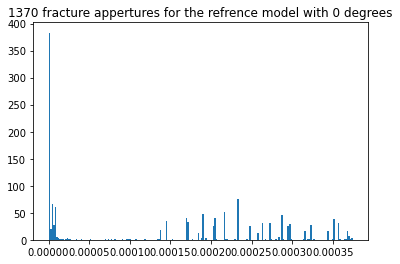

In [5]:
#%%
#First we define the model that will be used as refference with a 8138 distribution of fracture appertures - np.array with 8138 elements distributed from a uniform distribution
angle_ref = 0 #degress
NFractures = aperture_vec(angle_ref).shape[0]
frac_aper_het =  np.zeros(NFractures)
frac_aper_het = aperture_vec(angle_ref) #np.clip(np.random.normal(1e-3, 0.1*(1e-3), NFractures),0.0005,0.0015)
plt.hist(frac_aper_het, bins=200)
plt.title(f'{aperture_vec(angle_ref).shape[0]} fracture appertures for the refrence model with {angle_ref} degrees')
plt.show()

In [6]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true0 = ModelDA(frac_aper =aperture_vec(0))
time_range = np.arange(0,1000, 10)+1
# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).

m_true0.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true0.params.max_ts = 1  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true0.run(time_range[-1])


darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



In [7]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true90 = ModelDA(frac_aper =aperture_vec(90))
time_range = np.arange(0,1000, 10)+1
# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).

m_true90.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true90.params.max_ts = 1  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true90.run(time_range[-1])


darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



In [8]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true45 = ModelDA(frac_aper =aperture_vec(45))
time_range = np.arange(0,1000, 10)+1
# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).

m_true45.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true45.params.max_ts = 1  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true45.run(time_range[-1])


darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



In [9]:
time_data0 = pd.DataFrame.from_dict(m_true0.physics.engine.time_data)
time_data45 = pd.DataFrame.from_dict(m_true45.physics.engine.time_data)
time_data90 = pd.DataFrame.from_dict(m_true90.physics.engine.time_data)




In [10]:
from darts.tools.plot_darts import *
prod0 = m_true0.reservoir.wells[1]
prod45 = m_true45.reservoir.wells[1]
prod90 = m_true90.reservoir.wells[1]


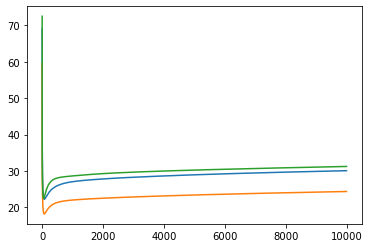

In [10]:
plt.plot(time_data0['time'],-1*time_data0['P1 : oil rate (m3/day)'])
plt.plot(time_data45['time'],-1*time_data45['P1 : oil rate (m3/day)'])
plt.plot(time_data90['time'],-1*time_data90['P1 : oil rate (m3/day)'])
plt.show()

Text(0.5, 0.98, 'Reference models P1 water rate and oil rate')

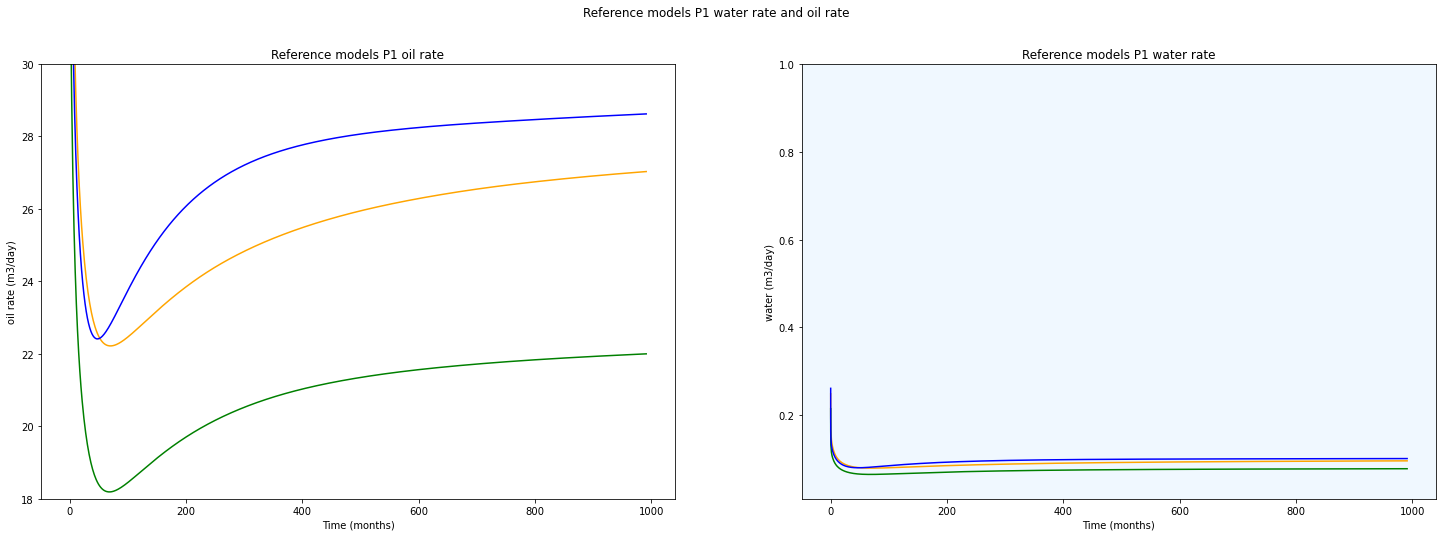

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(time_data0['time'],-1*time_data0['P1 : oil rate (m3/day)'], color='orange', alpha=1)
axFlat[0].plot(time_data45['time'],-1*time_data45['P1 : oil rate (m3/day)'], color='green',alpha=1)
axFlat[0].plot(time_data90['time'],-1*time_data90['P1 : oil rate (m3/day)'], color='blue', alpha=1)
axFlat[0].set_title('Reference models P1 oil rate')
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('oil rate (m3/day)')
axFlat[0].set_ylim([18, 30])

axFlat[1].set_facecolor('aliceblue')
axFlat[1].plot(time_data0['time'],-1*time_data0['P1 : water rate (m3/day)'], color='orange', alpha=1)
axFlat[1].plot(time_data45['time'],-1*time_data45['P1 : water rate (m3/day)'], color='green', alpha=1)
axFlat[1].plot(time_data90['time'],-1*time_data90['P1 : water rate (m3/day)'], color='blue', alpha=1)
axFlat[1].set_title('Reference models P1 water rate')
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('water (m3/day)')
axFlat[1].set_ylim([0.01, 1])
fig.suptitle('Reference models P1 water rate and oil rate')


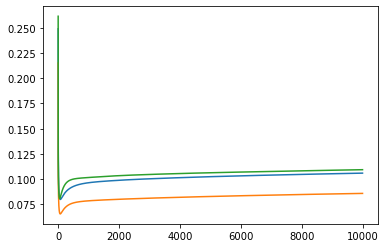

In [11]:
plt.plot(time_data0['time'],-1*time_data0['P1 : water rate (m3/day)'])
plt.plot(time_data45['time'],-1*time_data45['P1 : water rate (m3/day)'])
plt.plot(time_data90['time'],-1*time_data90['P1 : water rate (m3/day)'])
plt.show()



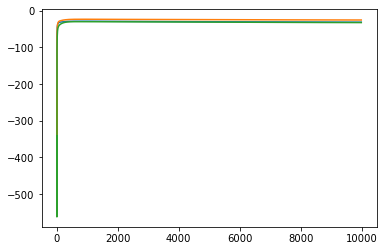

In [13]:
plt.plot(time_data0['time'],-1*time_data0['I1 : water rate (m3/day)'])
plt.plot(time_data45['time'],-1*time_data45['I1 : water rate (m3/day)'])
plt.plot(time_data90['time'],-1*time_data90['I1 : water rate (m3/day)'])
plt.show()


In [15]:
!jupyter nbconvert --to html teste_angleref.ipynb

[NbConvertApp] Converting notebook teste_angleref.ipynb to html
[NbConvertApp] Writing 351074 bytes to teste_angleref.html
